## Time Series Analysis with Pandas

This notebook is a follow along from this article: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

The data set: `Open Power Systems Data`

The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. 

Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:

Date — The date (yyyy-mm-dd format)
Consumption — Electricity consumption in GWh
Wind — Wind power production in GWh
Solar — Solar power production in GWh
Wind+Solar — Sum of wind and solar power production in GWh


We will explore how electricity consumption and production in Germany have varied over time, using pandas time series tools to answer questions such as:

1. When is electricity consumption typically highest and lowest?
2. How do wind and solar power production vary with seasons of the year?
3. What are the long-term trends in electricity consumption, solar power, and wind power?
4. How do wind and solar power production compare with electricity consumption, and how has this ratio changed over time?

### Pandas data structures for working with dates and times

In [3]:
import pandas as pd

pd.to_datetime('2020-01-15 2:15pm')

Timestamp('2020-01-15 14:15:00')

In [9]:
pd.to_datetime('9/12/1967')

Timestamp('1967-09-12 00:00:00')

In [10]:
pd.to_datetime('9/12/1967', dayfirst=True)

Timestamp('1967-12-09 00:00:00')

'9/12/1967' is assumed to be `month/day/year` and is interpreted as September 12, 1967. <br/>Alternatively, we can use the `dayfirst` parameter to tell pandas to interpret the date as December 9, 1967.

**If we supply a list or array of strings as input to to_datetime(), it returns a sequence of date/time values in a `DatetimeIndex` object, which is the core data structure that powers much of pandas time series functionality.**

In [11]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

In [12]:
%timeit pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'], format='%m/%d/%y')

328 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'])

591 µs ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 For very large data sets, specifying the date format can greatly speed up the performance of `to_datetime()` compared to the default behavior, 
 where the format is inferred separately for each individual string. 

#### Creating a time series DataFrame

In [15]:
opsd_daily = pd.read_csv('./opsd_germany_daily.csv')

In [16]:
opsd_daily.shape

(4383, 5)

In [18]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [19]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


Check out the data types of each column:

In [22]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

Now that the Date column is the correct data type, let’s set it as the DataFrame’s index.

In [28]:
opsd_daily = opsd_daily.set_index('Date')

In [29]:
opsd_daily.tail(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


In [30]:
opsd_daily.index

Index(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05',
       '2006-01-06', '2006-01-07', '2006-01-08', '2006-01-09', '2006-01-10',
       ...
       '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
       '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31'],
      dtype='object', name='Date', length=4383)

<hr/>
Alternatively, we can consolidate the above steps into a single line, using the index_col and parse_dates parameters of the read_csv() function. This is often a useful shortcut.

In [31]:
opsd_daily = pd.read_csv('./opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [32]:
opsd_daily.tail(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


In [40]:
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Week Day Name'] = opsd_daily.index.day_name()
opsd_daily['Day'] = opsd_daily.index.day

In [41]:
opsd_daily.sample(5, random_state=42)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Week Day Name,Day
Date,,,,,,,,
2007-11-02,1408.209,NaN,NaN,NaN,2007,11,Friday,2
2012-08-14,1269.779,64.136,153.658,217.794,2012,8,Tuesday,14
2007-08-20,1373.403,NaN,NaN,NaN,2007,8,Monday,20
2013-03-14,1420.149,28.595,62.718,91.313,2013,3,Thursday,14
2009-10-27,1405.611,NaN,NaN,NaN,2009,10,Tuesday,27


### Time-based indexing

 With time-based indexing, we can use date/time formatted strings to select data in our DataFrame with the loc accessor. The indexing works similar to standard label-based indexing with loc, but with a few additional features.

In [42]:
opsd_daily.loc['2017-08-10']

Consumption       1351.49
Wind              100.274
Solar               71.16
Wind+Solar        171.434
Year                 2017
Month                   8
Week Day Name    Thursday
Day                    10
Name: 2017-08-10 00:00:00, dtype: object

In [45]:
opsd_daily.loc['2014-01-30':'2014-02-01']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Week Day Name,Day
Date,,,,,,,,
2014-01-30,1651.529,167.885,37.222,205.107,2014,1,Thursday,30
2014-01-31,1605.265,112.603,45.499,158.102,2014,1,Friday,31
2014-02-01,1391.430,282.132,41.298,323.430,2014,2,Saturday,1


Another very handy feature of pandas time series is partial-string indexing, where we can select all date/times which partially match a given string. 

For example, we can select the entire year 2006 with `opsd_daily.loc['2006']`, or the entire month of February 2012 with `opsd_daily.loc['2012-02']`.

In [46]:
opsd_daily.loc['2006-02']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Week Day Name,Day
Date,,,,,,,,
2006-02-01,1582.134,NaN,NaN,NaN,2006,2,Wednesday,1
2006-02-02,1595.717,NaN,NaN,NaN,2006,2,Thursday,2
2006-02-03,1577.786,NaN,NaN,NaN,2006,2,Friday,3
2006-02-04,1366.322,NaN,NaN,NaN,2006,2,Saturday,4
2006-02-05,1258.013,NaN,NaN,NaN,2006,2,Sunday,5
2006-02-06,1557.525,NaN,NaN,NaN,2006,2,Monday,6
2006-02-07,1606.667,NaN,NaN,NaN,2006,2,Tuesday,7
2006-02-08,1590.896,NaN,NaN,NaN,2006,2,Wednesday,8
2006-02-09,1599.129,NaN,NaN,NaN,2006,2,Thursday,9


### Visualizing time series data

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='Date'>

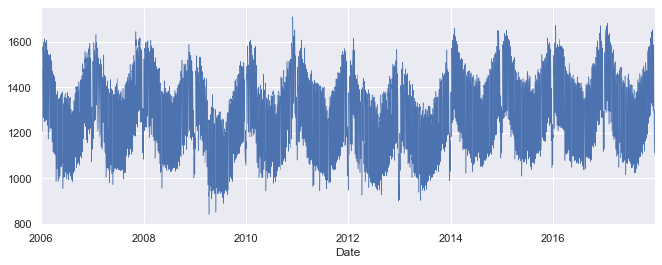

In [48]:
sns.set(rc={'figure.figsize':(11,4)})


opsd_daily['Consumption'].plot(linewidth=0.5)

We can see that the plot() method has chosen pretty good tick locations (every two years) and labels (the years) for the x-axis, which is helpful. However, with so many data points, the line plot is crowded and hard to read. Let’s plot the data as dots instead, and also look at the Solar and Wind time series.

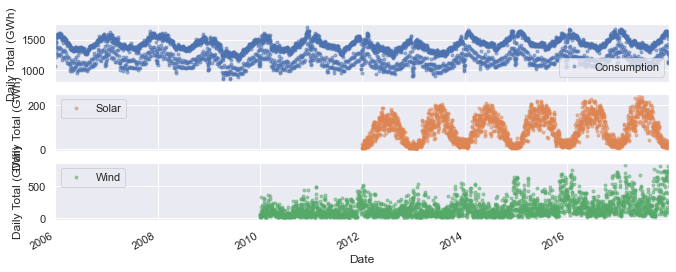

In [52]:
cols_plot = ['Consumption', 'Solar', 'Wind']


axes = opsd_daily[cols_plot].plot(marker='.', 
                                  alpha=0.5, 
                                  linestyle='None', 
                                  figsize=(11, 4), 
                                  subplots=True)

for ax in axes:
    ax.set_ylabel("Daily Total (GWh)")

 Let’s plot the time series in a single year

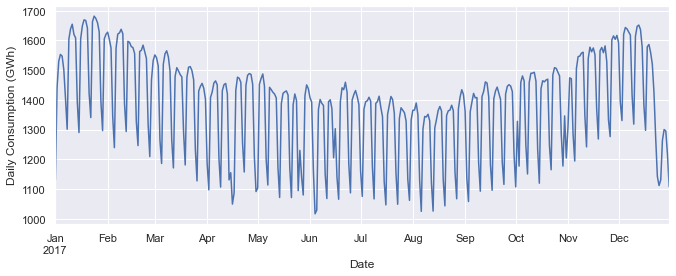

In [55]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

Now we can clearly see the weekly oscillations. Another interesting feature that becomes apparent at this level of granularity is the drastic decrease in electricity consumption in early January and late December, during the holidays.

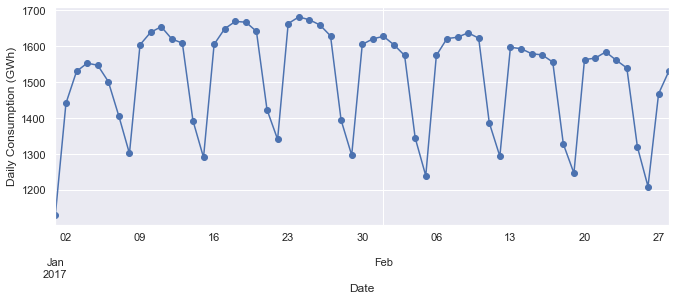

In [57]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');


As we suspected, consumption is highest on weekdays and lowest on weekends.

### Customizing time series plots

To better visualize the weekly seasonality in electricity consumption in the plot above, it would be nice to have vertical gridlines on a weekly time scale (instead of on the first day of each month). We can customize our plot with matplotlib.dates:

In [58]:
import matplotlib.dates as mdates

Because date/time ticks are handled a bit differently in matplotlib.dates compared with the DataFrame’s plot() method, let’s create the plot directly in matplotlib. Then we use mdates.WeekdayLocator() and mdates.MONDAY to set the x-axis ticks to the first Monday of each week. We also use mdates.DateFormatter() to improve the formatting of the tick labels, using the format codes we saw earlier.

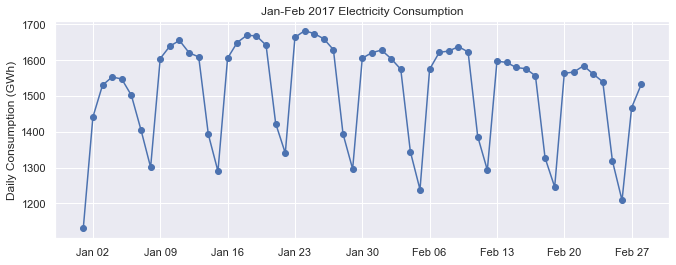

In [60]:
fix, ax = plt.subplots()

ax.plot(opsd_daily.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')

ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')

# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

### Seasonality

Next, let’s further explore the seasonality of our data with box plots, using seaborn’s boxplot() function to group the data by different time periods and display the distributions for each group. We’ll first group the data by month, to visualize yearly seasonality.

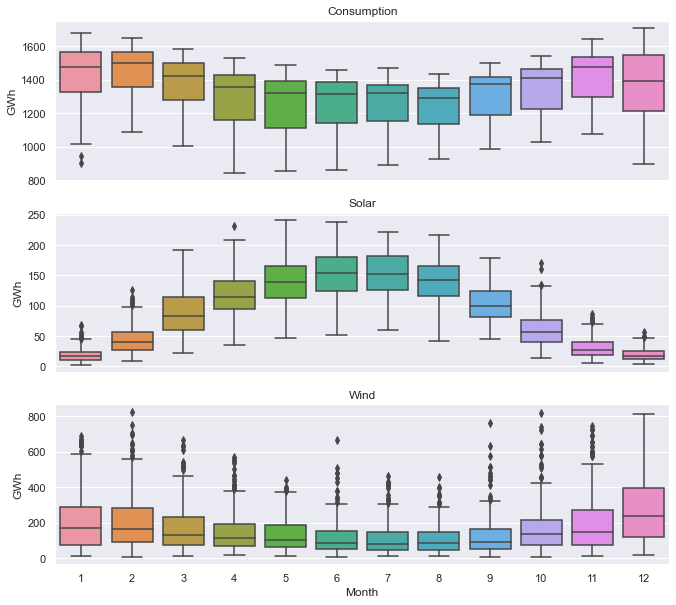

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
    sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

Next, let’s group the electricity consumption time series by day of the week, to explore weekly seasonality.

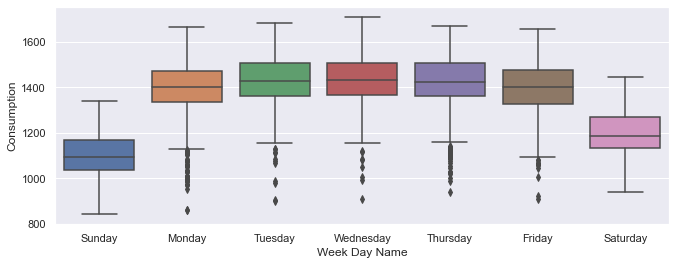

In [66]:
sns.boxplot(data=opsd_daily, x='Week Day Name', y='Consumption');


### Frequencies

When the data points of a time series are uniformly spaced in time (e.g., hourly, daily, monthly, etc.), the time series can be associated with a frequency in pandas. For example, let’s use the date_range() function to create a sequence of uniformly spaced dates from 1998-03-10 through 1998-03-15 at daily frequency.

In [67]:
pd.date_range('1998-03-10', '1998-03-15', freq='D')


DatetimeIndex(['1998-03-10', '1998-03-11', '1998-03-12', '1998-03-13',
               '1998-03-14', '1998-03-15'],
              dtype='datetime64[ns]', freq='D')

As another example, let’s create a date range at hourly frequency, specifying the start date and number of periods, instead of the start date and end date.

In [69]:
pd.date_range('2004-09-20', periods=8, freq='H')


DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [70]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

We can see that it has no frequency (freq=None). This makes sense, since the index was created from a sequence of dates in our CSV file, without explicitly specifying any frequency for the time series.

If we know that our data should be at a specific frequency, we can use the DataFrame’s asfreq() method to assign a frequency. If any date/times are missing in the data, new rows will be added for those date/times, which are either empty (NaN), or filled according to a specified data filling method such as forward filling or interpolation.

To see how this works, let’s create a new DataFrame which contains only the Consumption data for Feb 3, 6, and 8, 2013.

In [71]:
# To select an arbitrary sequence of date/time values from a pandas time series,
# we need to use a DatetimeIndex, rather than simply a list of date/time strings
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])
# Select the specified dates and just the Consumption column
consum_sample = opsd_daily.loc[times_sample, ['Consumption']].copy()
consum_sample

,Consumption
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


Now we use the asfreq() method to convert the DataFrame to daily frequency, with a column for unfilled data, and a column for forward filled data.

In [72]:
# Convert the data to daily frequency, without filling any missings
consum_freq = consum_sample.asfreq('D')
# Create a column with missings forward filled
consum_freq['Consumption - Forward Fill'] = consum_sample.asfreq('D', method='ffill')
consum_freq

,Consumption,Consumption - Forward Fill
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


In the Consumption column, we have the original data, with a value of NaN for any date that was missing in our consum_sample DataFrame. In the Consumption - Forward Fill column, the missings have been forward filled, meaning that the last value repeats through the missing rows until the next non-missing value occurs.

If you’re doing any time series analysis which requires uniformly spaced data without any missings, you’ll want to use asfreq() to convert your time series to the specified frequency and fill any missings with an appropriate method.

### Resampling


It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (downsampling) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. The daily OPSD data we’re working with in this tutorial was downsampled from the original hourly time series. Resampling to a higher frequency (upsampling) is less common and often involves interpolation or other data filling method — for example, interpolating hourly weather data to 10 minute intervals for input to a scientific model.

We will focus here on downsampling, exploring how it can help us analyze our OPSD data on various time scales. We use the DataFrame’s resample() method, which splits the DatetimeIndex into time bins and groups the data by time bin. The resample() method returns a Resampler object, similar to a pandas GroupBy object. We can then apply an aggregation method such as mean(), median(), sum(), etc., to the data group for each time bin.

For example, let’s resample the data to a weekly mean time series.

In [74]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
# Resample to weekly frequency, aggregating with mean
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


The first row above, labelled 2006-01-01, contains the mean of all the data contained in the time bin 2006-01-01 through 2006-01-07. The second row, labelled 2006-01-08, contains the mean data for the 2006-01-08 through 2006-01-14 time bin, and so on. By default, each row of the downsampled time series is labelled with the right edge of the time bin.

By construction, our weekly time series has 1/7 as many data points as the daily time series. We can confirm this by comparing the number of rows of the two DataFrames.

In [75]:
print(opsd_daily.shape[0])
print(opsd_weekly_mean.shape[0])

4383
627


Let’s plot the daily and weekly Solar time series together over a single six-month period to compare them.

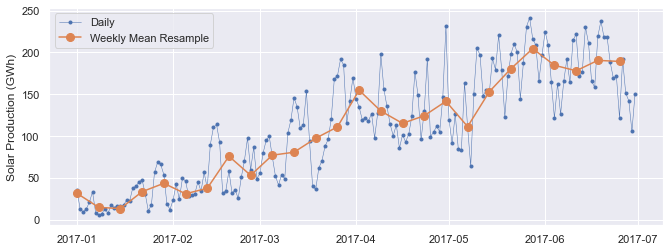

In [76]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();


We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling.

Now let’s resample the data to monthly frequency, aggregating with sum totals instead of the mean. Unlike aggregating with mean(), which sets the output to NaN for any period with all missing data, the default behavior of sum() will return output of 0 as the sum of missing data. We use the min_count parameter to change this behavior.

In [77]:
# Compute the monthly sums, setting the value to NaN for any month which has
# fewer than 28 days of data
opsd_monthly = opsd_daily[data_columns].resample('M').sum(min_count=28)
opsd_monthly.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN


You might notice that the monthly resampled data is labelled with the end of each month (the right bin edge), whereas the weekly resampled data is labelled with the left bin edge. By default, resampled data is labelled with the right bin edge for monthly, quarterly, and annual frequencies, and with the left bin edge for all other frequencies. This behavior and various other options can be adjusted using the parameters listed in the resample() documentation.

Now let’s explore the monthly time series by plotting the electricity consumption as a line plot, and the wind and solar power production together as a stacked area plot.

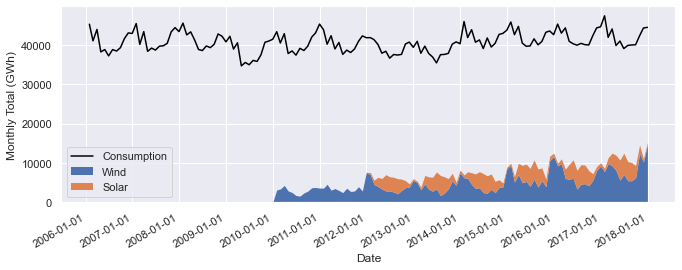

In [78]:
fig, ax = plt.subplots()
ax.plot(opsd_monthly['Consumption'], color='black', label='Consumption')
opsd_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

At this monthly time scale, we can clearly see the yearly seasonality in each time series, and it is also evident that electricity consumption has been fairly stable over time, while wind power production has been growing steadily, with wind + solar power comprising an increasing share of the electricity consumed.

Let’s explore this further by resampling to annual frequency and computing the ratio of Wind+Solar to Consumption for each year.

In [80]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
opsd_annual = opsd_daily[data_columns].resample('A').sum(min_count=360)
# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
opsd_annual = opsd_annual.set_index(opsd_annual.index.year)
opsd_annual.index.name = 'Year'
# Compute the ratio of Wind+Solar to Consumption
opsd_annual['Wind+Solar/Consumption'] = opsd_annual['Wind+Solar'] / opsd_annual['Consumption']
opsd_annual.tail(3)

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption
Year,,,,,
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2017,504736.36939,102667.365,35882.643,138550.008,0.274500


Finally, let’s plot the wind + solar share of annual electricity consumption as a bar chart.

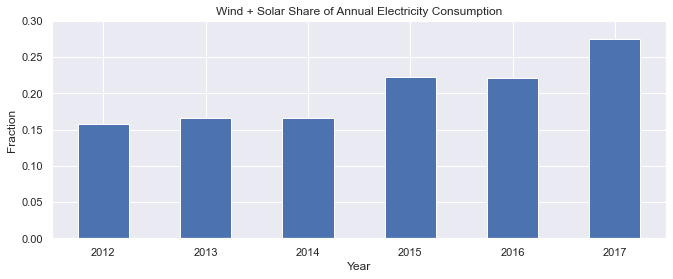

In [81]:
# Plot from 2012 onwards, because there is no solar production data in earlier years
ax = opsd_annual.loc[2012:, 'Wind+Solar/Consumption'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0);

We can see that wind + solar production as a share of annual electricity consumption has been increasing from about 15% in 2012 to about 27% in 2017.

### Rolling windows

Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as mean(), median(), sum(), etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.

By default, all data points within a window are equally weighted in the aggregation, but this can be changed by specifying window types such as Gaussian, triangular, and others. We’ll stick with the standard equally weighted window here.

Let’s use the rolling() method to compute the 7-day rolling mean of our daily data. We use the center=True argument to label each window at its midpoint, so the rolling windows are:

2006-01-01 to 2006-01-07 — labelled as 2006-01-04 <br/>
2006-01-02 to 2006-01-08 — labelled as 2006-01-05 <br/>
2006-01-03 to 2006-01-09 — labelled as 2006-01-06 <br/>
and so on…

In [83]:
# Compute the centered 7-day rolling mean
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


We can see that the first non-missing rolling mean value is on 2006-01-04, because this is the midpoint of the first rolling window.

To visualize the differences between rolling mean and resampling, let’s update our earlier plot of January-June 2017 solar power production to include the 7-day rolling mean along with the weekly mean resampled time series and the original daily data.

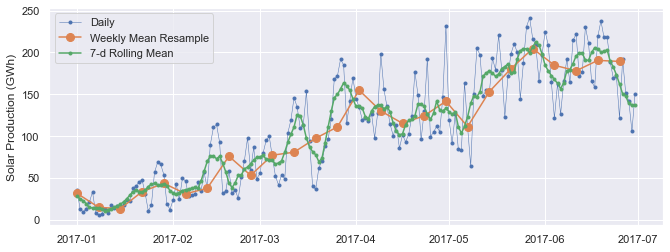

In [84]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'Solar'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();


We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

### Trends


Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean tends to smooth a time series by averaging out variations at frequencies much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let’s look at rolling means on those two time scales.

We’ve already computed 7-day rolling means, so now let’s compute the 365-day rolling mean of our OPSD data.

In [85]:
# The min_periods=360 argument accounts for a few isolated missing days in the
# wind and solar production time series
opsd_365d = opsd_daily[data_columns].rolling(window=365, center=True, min_periods=360).mean()

Let’s plot the 7-day and 365-day rolling mean electricity consumption, along with the daily time series.

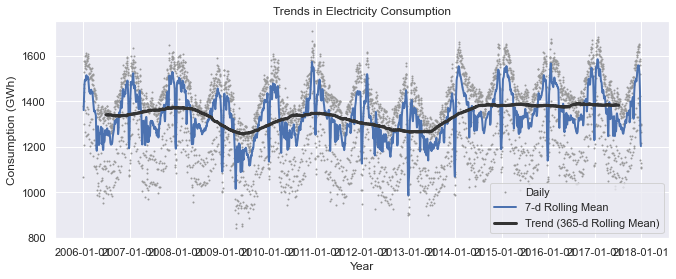

In [86]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(opsd_daily['Consumption'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(opsd_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')
ax.plot(opsd_365d['Consumption'], color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption');

We can see that the 7-day rolling mean has smoothed out all the weekly seasonality, while preserving the yearly seasonality. The 7-day rolling mean reveals that while electricity consumption is typically higher in winter and lower in summer, there is a dramatic decrease for a few weeks every winter at the end of December and beginning of January, during the holidays.

Looking at the 365-day rolling mean time series, we can see that the long-term trend in electricity consumption is pretty flat, with a couple of periods of anomalously low consumption around 2009 and 2012-2013.

Now let’s look at trends in wind and solar production.

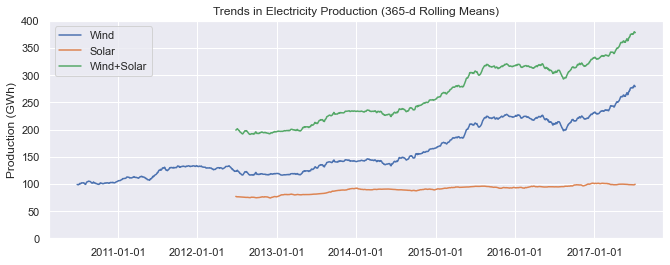

In [87]:
# Plot 365-day rolling mean time series of wind and solar power
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(opsd_365d[nm], label=nm)
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_ylim(0, 400)
    ax.legend()
    ax.set_ylabel('Production (GWh)')
    ax.set_title('Trends in Electricity Production (365-d Rolling Means)');


We can see a small increasing trend in solar power production and a large increasing trend in wind power production.